## Nuclear Masses

In [1]:
import ultranest
import scipy.stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import read as rd


from ultranest.plot import cornerplot

### Bayesian Inference

In [2]:
df = rd.read()
N = np.array(df["N"])
Z = np.array(df["Z"])
BE = np.array(df["binding"])*10**(-3)
BE_err = np.array(df["unc_binding"])*10**(-3)

### Models

In [42]:

def four_terms_model(a_v,a_s,a_c,a_a,N,Z):
    A = N + Z
    return (a_v - a_s*A**(-1/3) - a_c*Z*(Z-1)/(A**(4/3)) - a_a*((N-Z)**2)/A**2)

def five_terms_model(a_v, a_s, a_c, a_a, a_p, N, Z):
    A = N + Z
    ret = (a_v*A 
           - a_s*A**(2/3) 
           - a_c*Z*(Z - 1)/(A**(1/3)) 
           - a_a*((N - Z)**2)/A)

    A_even = (A % 2 == 0)
    addend = a_p * A**(-3/4)
    
    pairing = (
        np.logical_and(N % 2 == 0, Z % 2 == 0) * addend
        - np.logical_and(N % 2 == 1, Z % 2 == 1) * addend
    )
    ret += A_even * pairing

    return ret / A

In [55]:
print(BE)
print(four_terms_model(16,18,0.7,24,N,Z))
print(five_terms_model(16,18,0.7,24,34,N,Z))

[1.1122831  2.8272654  2.57268044 ... 7.2707598  7.2501551  7.2537634 ]
[1.71339053 0.8528304  0.5292618  ... 7.60269671 7.58191751 7.58251315]
[-8.39486995  0.8528304   0.5292618  ...  7.60075611  7.58191751
  7.58440372]


In [82]:
# Parameters
four_params = ['a_v', 'a_s', 'a_c', 'a_a']
five_params = ['a_v', 'a_s', 'a_c', 'a_a', 'a_p']

#loglikelihoods
def four_terms_loglikelihood(params):
    (a_v, a_s, a_c, a_a) = params
    model = four_terms_model(a_v, a_s, a_c, a_a, N, Z)
    if np.any(np.isnan(model)) or np.any(np.isinf(model)):
        return -np.inf
    chi2 = np.sum(((model - BE) / BE_err) ** 2)
    if np.isnan(chi2) or np.isinf(chi2):
        return -np.inf
    return -0.5 * chi2 - 0.5 * np.sum(np.log(2 * np.pi * BE_err ** 2))
    
    
def five_terms_loglikelihood(params):
    (a_v, a_s, a_c, a_a, a_p) = params
    model = five_terms_model(a_v, a_s, a_c, a_a, a_p, N, Z)
    if np.any(np.isnan(model)) or np.any(np.isinf(model)):
        return -np.inf
    chi2 = np.sum(((model - BE) / BE_err) ** 2)
    if np.isnan(chi2) or np.isinf(chi2):
        return -np.inf
    return -0.5 * chi2 - 0.5 * np.sum(np.log(2 * np.pi * BE_err ** 2))


#priors
def four_terms_prior(cube):
    a_v = 13 + 5 * cube[0]      # [13, 18]
    a_s = 15 + 6 * cube[1]      # [15, 21]
    a_c = 0.5 + 0.4 * cube[2]   # [0.5, 0.9]
    a_a = 0 + 30 * cube[3]      # [0, 30]
    return [a_v, a_s, a_c, a_a]
    

def five_terms_prior(cube):
    a_v = 13 + 5 * cube[0]
    a_s = 15 + 6 * cube[1]
    a_c = 0.5 + 0.4 * cube[2]
    a_a = 0 + 30 * cube[3]
    a_p = 20 + 30 * cube[4]
    return [a_v, a_s, a_c, a_a, a_p]



### Four Terms Model 

In [45]:
four_terms_sampler = ultranest.ReactiveNestedSampler(
    four_params, 
    four_terms_loglikelihood, 
    four_terms_prior, 
    log_dir='four_run/',
    resume=True
)

In [ ]:
four_terms_result = four_terms_sampler.run(min_num_live_points=1000, 
                                           dlogz=0.5,
                                           update_interval_volume_fraction=0.5,
                                           max_iters=100000,
                                           frac_remain=0.5,
                                           min_ess=300)

[ultranest] Resuming from 60076 stored points


[ultranest] Explored until L=-9e+13  5e+13 [-9.471e+13..-9.471e+13] | it/evals=59186/187099 eff=inf% N=64  
[ultranest] Likelihood function evaluations: 187099


/opt/anaconda3/lib/python3.12/site-packages/ultranest/integrator.py:2944: RuntimeWarning: invalid value encountered in scalar power
  results['logzerr_single'] = (main_iterator.all_H[0] / self.min_num_live_points)**0.5


[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest]   logZ = -9.471e+13 +- 0.2224
[ultranest] Effective samples strategy wants to improve: -94714210949917.11..-94714210949908.17 (ESS = 171.4, need >300)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.75+-0.41 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy wants 91 minimum live points (dlogz from 0.28 to 0.73, need <0.5)
[ultranest]   logZ error budget: single: 47992.62 bs:0.22 tail:0.53 total:0.58 required:<0.50
[ultranest] Widening from 263 to 526 live points before L=-9e+13...
[ultranest] Will add 263 live points (x1) at L=-9e+13 ...
[ultranest] Exploring (in particular: L=-94714210951098.59..-94714210949908.17) ...
[ultranest] Explored until L=-9e+13  5e+13 [-9.471e+13..-9.471e+13] | it/evals=60066/187148 eff=1683.6735% N=11  
[ultranest] Likelihood function evaluations: 187148


/opt/anaconda3/lib/python3.12/site-packages/ultranest/integrator.py:2944: RuntimeWarning: invalid value encountered in scalar power
  results['logzerr_single'] = (main_iterator.all_H[0] / self.min_num_live_points)**0.5


[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest] Will add 27 live points (x3) at L=-9e+13 ...
[ultranest] Explored until L=-9e+13  5e+13 [-9.471e+13..-9.471e+13] | it/evals=59920/187148 eff=inf% N=94  
[ultranest] Likelihood function evaluations: 187148


/opt/anaconda3/lib/python3.12/site-packages/ultranest/integrator.py:2944: RuntimeWarning: invalid value encountered in scalar power
  results['logzerr_single'] = (main_iterator.all_H[0] / self.min_num_live_points)**0.5


[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest] No changes made. Probably the strategy was to explore in the remainder, but it is irrelevant already; try decreasing frac_remain.
[ultranest] done iterating.



logZ = -94714210949974.172 +- 1.181
  single instance: logZ = -94714210949974.172 +- nan
  bootstrapped   : logZ = -94714210949973.781 +- 1.109
  tail           : logZ = +- 0.406
insert order U test : converged: True correlation: inf iterations

    a_v                 : 15.25509823│ ▁▁▁▁▁▁▁▁▁▁▁▂▂▂▅▄▆▆▇▅▅▇▅▄▂▂▂▂▁▁▁▁▁▁▁▁▁ │15.25510111    15.25509972 +- 0.00000031
    a_s                 : 16.13114049│ ▁▁▁▁▁▁▁▁▁▁▁▂▃▃▄▅▅▇▇▇▇▆▆▆▃▃▂▂▁▁▁▁▁▁▁▁▁ │16.13114570    16.13114319 +- 0.00000056
    a_c                 : 0.765770259│ ▁ ▁▁▁▁▁▁▁▁▁▂▂▃▄▅▆▆▆▇▇▇▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁ │0.765770797    0.765770535 +- 0.000000056
    a_a                 : 11.1731663│ ▁▁▁▁▁▁▁▁▁▁▂▂▃▅▄▇▇▇▇▇▇▅▄▅▄▃▂▂▁▁▁▁▁▁▁▁▁ │11.1731794    11.1731729 +- 0.0000016



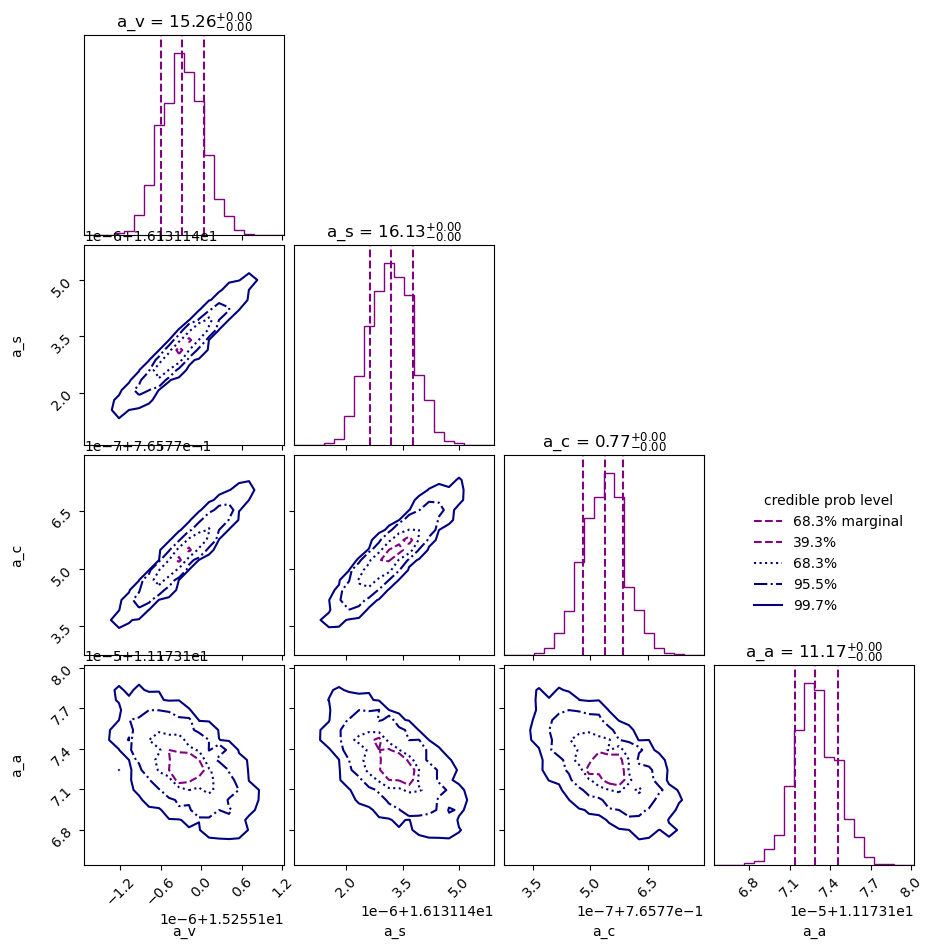

In [47]:
four_terms_sampler.print_results()
cornerplot(four_terms_result);

In [48]:
a_v_best = np.median(four_terms_result["samples"][:,0])
a_s_best = np.median(four_terms_result["samples"][:,1])
a_c_best = np.median(four_terms_result["samples"][:,2])
a_a_best = np.median(four_terms_result["samples"][:,3])

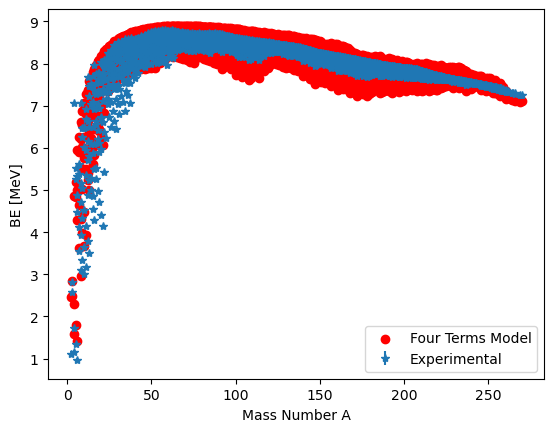

In [49]:
A = N + Z
n_points = 4000
plt.errorbar(A[:n_points], BE[:n_points], BE_err[:n_points], marker = "*" , ls = " ", label="Experimental")
BE_best = four_terms_model(a_v_best, a_s_best, a_c_best, a_a_best, N, Z)
plt.scatter(A[:n_points], BE_best[:n_points], color = 'red', label="Four Terms Model")
plt.xlabel('Mass Number A')
plt.ylabel('BE [MeV]')
plt.legend()

### Five Terms Model 

In [83]:
five_terms_sampler = ultranest.ReactiveNestedSampler(
    param_names=five_params, 
    loglike=five_terms_loglikelihood, 
    transform=five_terms_prior, 
    #log_dir='five_run/',
    resume=True
)

In [70]:
five_terms_result = five_terms_sampler.run(min_num_live_points=1000, 
                                           dlogz=0.5,
                                           update_interval_volume_fraction=0.5,
                                           max_iters=100000,
                                           frac_remain=0.1,
                                           min_ess=200)

[ultranest] Sampling 1000 live points from prior ...


[ultranest] Explored until L=-2e+14  e+14 [-2.161e+14..-2.161e+14] | it/evals=36782/156566 eff=23.6440% N=1000 
[ultranest] Likelihood function evaluations: 156566
[ultranest]   logZ = -2.161e+14 +- 5.969e+08
[ultranest] Effective samples strategy satisfied (ESS = 1.0, need >200)
[ultranest] Posterior uncertainty strategy wants to improve: -10397641706743372.00..-216082578576839.19 (KL: 386439613.76+-1272139644.14 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy wants 998 minimum live points (dlogz from 386439613.92 to 1658579257.56, need <0.5)
[ultranest]   logZ error budget: single: 0.21 bs:596887711.97 tail:0.69 total:596887711.97 required:<0.50
[ultranest] Widening from 1 to 2000 live points before L=-1e+16...
[ultranest] parent value is -inf, so widening roots
[ultranest] Widening roots to 2000 live points (have 1000 already) ...
[ultranest] Sampling 1000 live points from prior ...


/opt/anaconda3/lib/python3.12/site-packages/ultranest/integrator.py:1686: RuntimeWarning: invalid value encountered in divide
  p /= p.sum(axis=0).reshape((1, -1))


[ultranest] Exploring (in particular: L=-inf..-216082578576839.19) ...
[ultranest] Explored until L=-2e+14  e+14 [-inf..-2.161e+14] | it/evals=73565/323731 eff=22.1358% N=2000 
[ultranest] Likelihood function evaluations: 323731
[ultranest]   logZ = -2.161e+14 +- 5.651e+08
[ultranest] Effective samples strategy satisfied (ESS = 1.0, need >200)
[ultranest] Posterior uncertainty strategy wants to improve: -10785894218274820.00..-216082578576839.19 (KL: 399427652.99+-875482305.73 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy wants 1998 minimum live points (dlogz from 399427653.16 to 1274909958.25, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:565140199.19 tail:0.69 total:565140199.19 required:<0.50
[ultranest] Widening roots to 1998 live points (have 2000 already) ...
[ultranest] Exploring (in particular: L=-10785894218274820.00..-216082578576839.19) ...


/opt/anaconda3/lib/python3.12/site-packages/ultranest/integrator.py:1686: RuntimeWarning: invalid value encountered in divide
  p /= p.sum(axis=0).reshape((1, -1))


[ultranest] Explored until L=-2e+14  e+14 [-1.079e+16..-2.161e+14] | it/evals=73566/323732 eff=0.0000% N=2000 
[ultranest] Likelihood function evaluations: 323732
[ultranest]   logZ = -2.161e+14 +- 5.569e+08
[ultranest] Effective samples strategy satisfied (ESS = 1.0, need >200)
[ultranest] Posterior uncertainty strategy wants to improve: -10785894218274820.00..-216082578576839.19 (KL: 364282336.25+-910627622.47 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy wants 1998 minimum live points (dlogz from 364282336.41 to 1274909958.34, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:556945791.05 tail:0.69 total:556945791.05 required:<0.50
[ultranest] Widening from 1 to 4000 live points before L=-1e+16...
[ultranest] parent value is -inf, so widening roots
[ultranest] Widening roots to 4000 live points (have 2000 already) ...
[ultranest] Sampling 2000 live points from prior ...


/opt/anaconda3/lib/python3.12/site-packages/ultranest/integrator.py:1686: RuntimeWarning: invalid value encountered in divide
  p /= p.sum(axis=0).reshape((1, -1))


[ultranest] Exploring (in particular: L=-inf..-216082578576839.19) ...
[ultranest] Explored until L=-2e+14  e+14 [-inf..-2.161e+14] | it/evals=99990/524523 eff=25.2476% N=4000 
[ultranest] Likelihood function evaluations: 524543
[ultranest]   logZ = -2.161e+14 +- 5.762e+08
[ultranest] Effective samples strategy satisfied (ESS = 1.0, need >200)
[ultranest] Posterior uncertainty strategy wants to improve: -10885178103482626.00..-216082578576839.19 (KL: 375849793.27+-1039584678.51 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy wants 1998 minimum live points (dlogz from 375849793.46 to 1415434471.44, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:576226007.38 tail:0.69 total:576226007.38 required:<0.50


/opt/anaconda3/lib/python3.12/site-packages/ultranest/integrator.py:1686: RuntimeWarning: invalid value encountered in divide
  p /= p.sum(axis=0).reshape((1, -1))


[ultranest] Widening from 1 to 8000 live points before L=-1e+16...
[ultranest] parent value is -inf, so widening roots
[ultranest] Widening roots to 8000 live points (have 4000 already) ...
[ultranest] Sampling 4000 live points from prior ...
[ultranest] Exploring (in particular: L=-inf..-216082578576839.19) ...


KeyboardInterrupt: 

In [71]:
five_terms_sampler.print_results()
cornerplot(five_terms_result);


logZ = -216082578576883.656 +- 0.972
  single instance: logZ = -216082578576883.656 +- 0.149
  bootstrapped   : logZ = -216082954426676.438 +- 0.688
  tail           : logZ = +- 0.688
insert order U test : converged: True correlation: inf iterations

    a_v                 : 14.5425514712099204│                   ▇                   │15.6425514712099218    15.0925514712099265 +- 0.0000000000000053
    a_s                 : 15.0000060000000008│▇                                      │15.5500111228772280    15.0000111228772290 +- 0.0000000000000018
    a_c                 : 0.500 │                           ▇           │0.900     0.782 +- 0.000
    a_a                 : 14.7394000640101837│                   ▇                   │15.8394000640101851    15.2894000640101826 +- 0.0000000000000018
    a_p                 : 20.0000299999999989│                                       │20.5500173405219115    20.0000173405219108 +- 0.0000000000000036



/opt/anaconda3/lib/python3.12/site-packages/ultranest/integrator.py:3045: RuntimeWarning: invalid value encountered in divide
  dist = ''.join([' ▁▂▃▄▅▆▇██'[i] for i in np.ceil(H * 7 / H.max()).astype(int)])
/opt/anaconda3/lib/python3.12/site-packages/ultranest/integrator.py:3045: RuntimeWarning: invalid value encountered in cast
  dist = ''.join([' ▁▂▃▄▅▆▇██'[i] for i in np.ceil(H * 7 / H.max()).astype(int)])


In [60]:
a_v_best = np.median(five_terms_result["samples"][:,0])
a_s_best = np.median(five_terms_result["samples"][:,1])
a_c_best = np.median(five_terms_result["samples"][:,2])
a_a_best = np.median(five_terms_result["samples"][:,3])
a_p_best = np.median(five_terms_result["samples"][:,4])

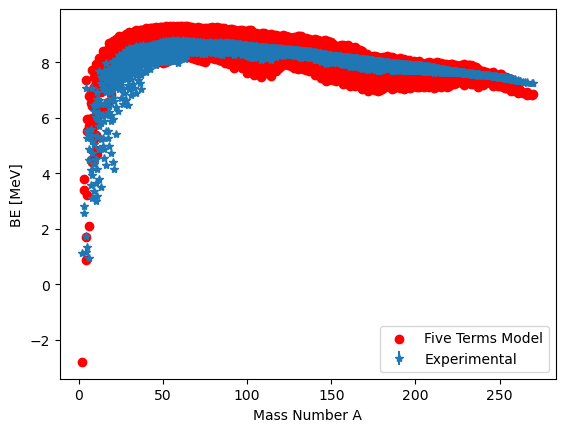

In [61]:
A = N + Z
n_points = 4000
plt.errorbar(A[:n_points], BE[:n_points], BE_err[:n_points], marker = "*" , ls = " ", label="Experimental")
BE_best = five_terms_model(a_v_best, a_s_best, a_c_best, a_a_best, a_p_best, N, Z)
plt.scatter(A[:n_points], BE_best[:n_points], color = 'red', label="Five Terms Model")
plt.xlabel('Mass Number A')
plt.ylabel('BE [MeV]')
plt.legend()